In [1]:
#######################################################################
# Copyright (C)                                                       #
# 2016 Shangtong Zhang(zhangshangtong.cpp@gmail.com)                  #
# 2016 Kenta Shimada(hyperkentakun@gmail.com)                         #
# 2017 Aja Rangaswamy (aja004@gmail.com)                              #
# Permission given to modify the code as long as you keep this        #
# declaration at the top                                              #
#######################################################################
#######################################################################
# Copyright (C)                                                       #
# 2017 Cheung Auyeung(cheung.auyeung@gmail.com)                       #
# Permission given to modify the code as long as you keep this        #
# declaration at the top                                              #
#######################################################################

Figure 4.2 shows the sequence of policies found by policy iteration starting from the
policy that never moves any cars.

In [2]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from math import *
import time 

In [3]:
def timeit(method):
    def timed(*args, **kw):
        _ts = time.time()
        result = method(*args, **kw)
        _te = time.time()

        print('%r  %2.2f s' % \
            (method.__name__, (_te - _ts) ))
        return result

    return timed

# Example 4.2 Car Rental 

Jack’s Car Rental Jack manages **two locations** for a nationwide
car rental company. Each day, some number of customers arrive at each location
to rent cars. 

If Jack has a car available, he rents it out and is **credited \$10** (`RENTAL_CREDIT`) per car rented by the
national company. If he is out of cars at that location, then the business is lost.
Cars become available for renting the day after they are returned. 

To help ensure
that cars are available where they are needed, Jack can move them between the two
locations overnight, at a **cost of \$2** (`MOVE_CAR_COST`) per car moved. 

We assume that the number of
cars **requested and returned** at each location are ***Poisson random variables***, meaning
that the probability that the number is n is $\frac{\lambda^n}{n!}e^{-\lambda}$, 
where $\lambda$ is the expected number.
Suppose $\lambda$ is
- 3 (`RENTAL_REQUEST_FIRST_LOC`) and 4 (`RENTAL_REQUEST_SECOND_LOC`) for rental requests at the first and second locations and 
- 3 (`RETURNS_FIRST_LOC`) and 2 (`RETURNS_SECOND_LOC`) for returns. 

To simplify the problem slightly, we assume that there can be **no more
than 20** cars (`MAX_CARS`) at each location (any **additional cars** are returned to the nationwide
company, and thus ***disappear*** from the problem) and a **maximum of five cars** (`MAX_MOVE_OF_CARS`) can
be moved from one location to the other in one night. 

We take the **discount rateto be $\gamma = 0.9$** (`DISCOUNT `) and formulate this as a continuing finite MDP, where 
- the **time steps** are days, 
- the **state** is the number of cars at each location at the **end of the day**, and
- the **actions** are the net numbers of cars moved between the two locations **overnight**.

In [4]:
# maximum # of cars in each location
MAX_CARS = 20

# maximum # of cars to move during night
MAX_MOVE_OF_CARS = 5

# expectation for rental requests in first location
RENTAL_REQUEST_FIRST_LOC = 3

# expectation for rental requests in second location
RENTAL_REQUEST_SECOND_LOC = 4

# expectation for # of cars returned in first location
RETURNS_FIRST_LOC = 3

# expectation for # of cars returned in second location
RETURNS_SECOND_LOC = 2

DISCOUNT = 0.9

# credit earned by a car
RENTAL_CREDIT = 10

# cost of moving a car
MOVE_CAR_COST = 2

In [5]:
# all possible states
states = []

# axes for printing use
AxisXPrint = []
AxisYPrint = []
for i in range(0, MAX_CARS + 1):
    for j in range(0, MAX_CARS + 1):
        AxisXPrint.append(i)
        AxisYPrint.append(j)
        states.append((i, j))

In [6]:
# plot a policy/state value matrix
figureIndex = 0
def prettyPrint(data, labels, elev=25, azim=-45):
    global figureIndex
    figureIndex += 1
    fig = plt.figure(figureIndex, figsize=(12, 6))
    
    ax = fig.add_subplot(121)
    im = ax.matshow(data,cmap="jet",origin='lower')
    fig.colorbar(im,fraction=0.046, pad=0.04)
    ax.set_xlabel(labels[1])
    ax.set_ylabel(labels[0])
    
    ax = fig.add_subplot(122, projection='3d')
    ax.view_init(elev, azim)
    AxisZ = []
    for i, j in states:
        AxisZ.append(data[i, j])
    ax.scatter(AxisXPrint, AxisYPrint, AxisZ)
    ax.set_xlabel(labels[1])
    ax.set_ylabel(labels[0])
    ax.set_zlabel(labels[2])
    ax.dist = 12
    

## Poisson random variables

The probability mass function of a Poission random varabile $n$ is $P(n\,;\,\lambda) = \frac{\lambda^n}{n!}e^{-\lambda}$, 
where $\lambda$ is the expected number.

To avoid recomputing $P(n\,;\,\lambda)$  by the function `poisson(n, lam)` for repeated values of $(n,\lambda)$, it uses a lookup table `poissonLUT[key]` to store the corresponding value on condition that $n < 11$ (`POISSON_UP_BOUND`) where
```python
    key = n * 10 + lam
```
and `lam` is $\lambda$. If the probability for $(n, \lambda)$ is in the lookup table, the value from the table is returned. Otherwise, a new value is inserted in the lookup table for future references and then the value is returned.

In [7]:
# An up bound for poisson distribution
# If n is greater than this value, then the probability of getting n is truncated to 0
POISSON_UP_BOUND = 11

# Probability for poisson distribution
# @lam: lambda should be less than 10 for this function
poissonLUT = dict()
def poisson(n, lam):
    global poissonBackup
    key = n * 10 + lam
    if key not in poissonLUT.keys():
        poissonLUT[key] = exp(-lam) * pow(lam, n) / factorial(n)
    return poissonLUT[key]

# Figure 4.2: Policy Iteration Example

Print the sequence of policies found by policy iteration on Jack’s car rental problem,
and the final state-value function. 

## Expected Return

The value function of a policy $\pi$ is found by solving the
Bellman equation for $v_\pi(s)$:

$$
\begin{align}
v_\pi(s)\, &=\, E\left[ q(s,a) \,|\,s \right] \\
{}\, &=\, \sum_{a} \pi(a\,|\,s) \, q(s,a) 
\end{align}
$$

where 
$$
\begin{align}
q(s,a)\, &=\,  \sum_{s',r} p(s',r\,|\,s,a) \left[ r + \gamma v_\pi(s') \right]  \\
{}\, &=\, E\left[ r + \gamma v_\pi(s') \,|\,s,a \right]
\end{align}
$$

is the expected return at state $s$ taking action $a$. 

The expected return $q(s,a)$ is a functon of $s$ (`state`) and $a$ (`action`) when given $v_\pi(s)$ (`stateValue`). It is computed by the following function `expecedReturn`.

In this example, $s_\max$ is the size of the two parking lots. For the parking lot $i \in \{0,1\}$,  $s_i$ is the number of cars at the end of a day, $s'_i$ is the number of cars at the end of the next day. The action $a$ is the number of car moved from parking lot 0 to parking lot 1.

Let $c_{\text{req},i}$ be the number of car requested and $c_{\text{ret},i}$ be the number of car returned at parking lot $i$. For $s_\max \ge s_i - (-1)^ia \ge 0$, $s_i-(-1)^ia$ is the number of cars in the morning and $\min\left(c_{\text{req},\,i}\,,\,s_i-(-1)^ia\right)$ is the number of cars rented on the next day. Consequently, the number of cars in the parking lot $i$ at the end of the next day is

$$
    s'_i = \min\left[(s_i - (-1)^ia) - \min\left(c_{\text{req},\,i}\,,\,s-(-1)^ia\right) + c_{\text{ret},\,i}\,,\, s_{\max}\right]
$$

It is a function of the random variables $c_{\text{req},\,i}$ and $c_{\text{ret},\,i}$. Also the reward is

$$
    r = r_\text{move} + r_{\text{rent}} \\
$$

where

$$
\begin{align}
r_\text{move} &= -2 \cdot |a| \\ 
r_{\text{rent}} &=  10\cdot\min\left(c_{\text{req}\,,0}\,,\,s_0-a\right) + 10\cdot\min\left(c_{\text{req},\,1}\,,\,s_1+a\right)
\end{align}
$$

The reward $r$ is a function of the random variables $c_{\text{req},\,i}$. Therefore,


$$
\begin{align}
q(s,a)\, &=\, E\left[ r + \gamma v_\pi(s') \,|\,s,a \right] \\ 
{}\, &=\, \sum_{c_{\text{req}}} \sum_{c_{\text{ret}}} p(c_{\text{req}})p(c_{\text{ret}}) \left[ r + \gamma v_\pi(s') \right]  \\
{}\, &=\, \sum_{c_{\text{req}}} p(c_{\text{req}}) \left[ r + \sum_{c_{\text{ret}}} p(c_{\text{ret}})\cdot\gamma v_\pi(s') \right] \\
{}\, &=\, r_\text{move} + \sum_{c_{\text{req}}} p(c_{\text{req}}) \left[ r_\text{rent} + \gamma\sum_{c_{\text{ret}}} p(c_{\text{ret}})\cdot v_\pi(s') \right]
\end{align}
$$

The following function `expectedReturn(state, action, stateValue)` compute $q(s,a)$ given the state value $v_\pi(s')$

In [8]:
# @state: [# of cars in first location, # of cars in second location]
# @action: positive if moving cars from first location to second location,
#          negative if moving cars from second location to first location
# @stateValue: state value matrix
def expectedReturn(state, action, stateValue):
    # initailize total return
    returns = 0.0

    # cost for moving cars
    returns -= MOVE_CAR_COST * abs(action)

    # number of cars after moving cars
    numOfCarsFirstLoc_0 = int(min(state[0] - action, MAX_CARS))
    numOfCarsSecondLoc_0 = int(min(state[1] + action, MAX_CARS))
    
    # go through all possible rental requests
    for rentalRequestFirstLoc in range(0, POISSON_UP_BOUND):
        for rentalRequestSecondLoc in range(0, POISSON_UP_BOUND):
            # cars when the business day begins
            numOfCarsFirstLoc =  numOfCarsFirstLoc_0
            numOfCarsSecondLoc = numOfCarsSecondLoc_0
            
            # valid rental requests should be less than actual # of cars
            realRentalFirstLoc = min(numOfCarsFirstLoc, rentalRequestFirstLoc)
            realRentalSecondLoc = min(numOfCarsSecondLoc, rentalRequestSecondLoc)

            # get credits for renting
            reward_rent = (realRentalFirstLoc + realRentalSecondLoc) * RENTAL_CREDIT
            numOfCarsFirstLoc -= realRentalFirstLoc
            numOfCarsSecondLoc -= realRentalSecondLoc

            # probability for current combination of rental requests
            prob_req = poisson(rentalRequestFirstLoc, RENTAL_REQUEST_FIRST_LOC) * \
                         poisson(rentalRequestSecondLoc, RENTAL_REQUEST_SECOND_LOC)

            # if set True, model is simplified such that the # of cars 
            # returned in daytime becomes constant
            # rather than a random value from poisson distribution, 
            # which will reduce calculation time
            # and leave the optimal policy/value state matrix almost the same
            constantReturnedCars = True
            if constantReturnedCars:
                # get returned cars, those cars can be used for renting tomorrow
                returnedCarsFirstLoc = RETURNS_FIRST_LOC
                returnedCarsSecondLoc = RETURNS_SECOND_LOC
                numOfCarsFirstLoc = min(numOfCarsFirstLoc + returnedCarsFirstLoc, 
                                        MAX_CARS)
                numOfCarsSecondLoc = min(numOfCarsSecondLoc + returnedCarsSecondLoc, 
                                         MAX_CARS)
                returns += prob_req * \
                    (reward_rent + DISCOUNT * stateValue[numOfCarsFirstLoc, numOfCarsSecondLoc])
            else:
                numOfCarsFirstLoc_ = numOfCarsFirstLoc
                numOfCarsSecondLoc_ = numOfCarsSecondLoc
                returns_future = 0.0
                for returnedCarsFirstLoc in range(0, POISSON_UP_BOUND):
                    for returnedCarsSecondLoc in range(0, POISSON_UP_BOUND):
                        numOfCarsFirstLoc = numOfCarsFirstLoc_
                        numOfCarsSecondLoc = numOfCarsSecondLoc_
                        numOfCarsFirstLoc = min(numOfCarsFirstLoc + returnedCarsFirstLoc, 
                                                MAX_CARS)
                        numOfCarsSecondLoc = min(numOfCarsSecondLoc + returnedCarsSecondLoc, 
                                                 MAX_CARS)
                        prob_ret = poisson(returnedCarsFirstLoc, RETURNS_FIRST_LOC) * \
                                    poisson(returnedCarsSecondLoc, RETURNS_SECOND_LOC)
                        returns_future += prob_ret * \
                                    stateValue[numOfCarsFirstLoc, numOfCarsSecondLoc]
                returns += prob_req * (reward_rent + DISCOUNT * returns_future)
    return returns

1. In  this particular implementation, initlialse $V(s)$ (`stateVaule[state]`) and $\pi(s)$ (`policy[state]`) for all $s$ (`state`) to zero.

2. Policy Evaluation  
Repeat    
$\qquad$ For each $s \in S$:  
$\qquad\qquad v(s) \leftarrow q(s,\pi(s);V)$  
$\qquad \Delta \leftarrow ||v - V||_1$  
$\qquad V \leftarrow v $   
until $\Delta < \theta$ (a small positive number), where $q(s,\pi(s);V)$ is computed by the function `expectedReturn(state, action, stateValue)`.

3. Policy Improvement      
For each $s \in S$:   
$\qquad \pi_{\text{new}}(s) \leftarrow \mathrm{argmax}_a q(s,a;V)$   
where $q(s,a;V)$ is computed by the function 
`expectedReturn(state, action, stateValue)`.       
If $||\pi_{\text{new}} - \pi||_1 = 0$ then     
$\qquad$ stop and return $V$ as $V_\ast$ and $\pi$ as $\pi_\ast$  
else   
$\qquad \pi \leftarrow \pi_{\text{new}}$    
$\qquad$go to 2 

In [ ]:
def policyShow(policy,index) :
    im = plt.matshow(policy,cmap="jet",origin='lower')
    plt.colorbar(im,fraction=0.046, pad=0.04)
    plt.ylabel('# of cars in first location')
    plt.xlabel('# of cars in second location')
    plt.title('Policy at iteration {}'.format(index))
    plt.show()

@timeit
def figure4_2() :
    # current policy
    policy = np.zeros((MAX_CARS + 1, MAX_CARS + 1))     

    # current state value
    stateValue = np.zeros((MAX_CARS + 1, MAX_CARS + 1))

    # all possible actions
    actions = np.arange(-MAX_MOVE_OF_CARS, MAX_MOVE_OF_CARS + 1)

    newStateValue = np.zeros((MAX_CARS + 1, MAX_CARS + 1))
    
    policyImprovementInd = 0    
    policyShow(policy,policyImprovementInd)
    policyImprovementInd += 1   
    
    policyConverged = False        
    while not policyConverged: 
        # start policy evaluation
        print('Policy Evaluation ', policyImprovementInd)
        stateValueConverged = False
        k = 0
        ts = time.time()
        while not stateValueConverged :
            for state in states:
                newStateValue[state] = expectedReturn(
                    state, policy[state], stateValue)

            if np.sum(np.abs(newStateValue - stateValue)) < 1e-4: 
                stateValueConverged = True

            stateValue[:] = newStateValue 
            k += 1
        te = time.time()    
        print('State value converged in {} iterations and {:.2f} seconds'
              .format(k, te-ts))

        # start policy improvement
        print('Policy improvement', policyImprovementInd)
        newPolicy = np.zeros((MAX_CARS + 1, MAX_CARS + 1))
        ts = time.time()
        for state in states:
            actionReturns = []
            # go through all actions and select the best one
            for action in actions:
                if ((action >= 0 and action <= state[0]) or 
                    (action < 0 and  abs(action) <= state[1])):
                    actionReturns.append(
                        expectedReturn(state, action, stateValue))
                else:
                    actionReturns.append(-float('inf'))
            bestAction = np.argmax(actionReturns)
            newPolicy[state] = actions[bestAction]
        te = time.time()    
        print('Policy improvment computed in {:.2f} seconds'.format(te-ts))

        # if policy is stable
        policyChanges = np.sum(newPolicy != policy)
        print('New policy has', policyChanges, 'states changed')            

        if policyChanges == 0:   
            policyConverged = True
        else :           
            policy = newPolicy
            policyShow(policy,policyImprovementInd)     
            policyImprovementInd += 1
            
    labels = ['# of cars in first location', '# of cars in second location', 
              '# of cars to move during night']
    prettyPrint(policy, labels, elev=30, azim=-15)
    plt.show()

    labels = ['# of cars in first location', '# of cars in second location', 
              'expected returns']
    prettyPrint(stateValue, labels, elev=25, azim=-50)
    plt.show()    

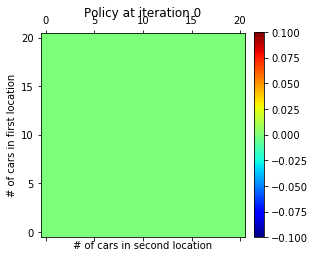

Policy Evaluation  1
State value converged in 178 iterations and 24.88 seconds
Policy improvement 1
Policy improvment computed in 1.42 seconds
New policy has 332 states changed


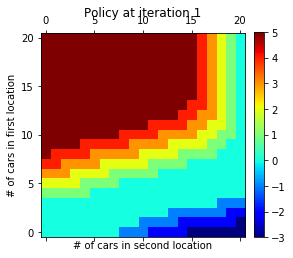

Policy Evaluation  2


In [ ]:
figure4_2()